In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from deep_translator import GoogleTranslator
from augmentex.char import CharAug
from time import sleep
from random import shuffle

tqdm.pandas()

### Preparation

In [48]:
# text augmentation class
class TextAugmentation:
    def __init__(self):
        self.__translator = GoogleTranslator()
        self.__deffault_languages = ['ru', 'zh-TW', 'ar', 'ak', 'ru']
        self.__corruptor = CharAug(unit_prob=0.02, 
                                   min_aug=1, 
                                   max_aug=3, 
                                   mult_num=3)
    
    # split text for batches
    def split_text(self, text, max_length):
        # split the text into words 
        words = text.split()

        result = []
        current_chunk = []

        for word in words:
            if len(' '.join(current_chunk)) + len(word) + len(current_chunk) <= max_length:
                # add the word to the current chunk
                current_chunk.append(word)
            else:
                # start a new chunk
                result.append(' '.join(current_chunk))
                current_chunk = [word]

        if current_chunk:
            # add the last chunk to the result
            result.append(' '.join(current_chunk))

        return result
    
    # translate large texts (>2000 symbols)
    def translation_large(self, text, langs=['ru', 'zh-TW', 'ak', 'ar', 'ru']):
        batches = self.split_text(text, 2000)
        result = ""
        
        for batch in batches:
            result += str(self.translation(batch, langs=langs))
            sleep(0.1)
        return result
        
    # translate texts
    def translation(self, text, langs=['ru', 'zh-TW', 'ak', 'ar', 'ru']):
        if len(text) > 3000:
            text = self.translation_large(text, langs=langs)
            return text
        
        # trash text
        if len(text) < 3:
            return ''
        
        text = text[:5000-1]
        number = len(langs)-1
        for i in range(number):
            self.__translator.source = langs[i]
            self.__translator.target = langs[i+1]
            text = self.__translator.translate(text)
            sleep(0.1)
            
        return text
    
    # corruptor with char augmentation
    def corruption(self, text, seed=None):
        return self.__corruptor.augment(text=text)
    
    # translation + char corruption
    def translation_corruption(self, text, langs=['ru', 'zh-TW', 'ak', 'ar', 'ru'], seed=None):
        text = self.translation(text, langs=langs)
        return self.corruption(text, seed=seed)
    
    # translation aug for dataframes with multiplier
    def tr_df(self, df, label, mult=1.5, langs=['ru', 'zh-TW', 'ak', 'ar', 'ru']):
        label_df = df[df['label'] == label]
        num_rows = label_df.shape[0]
        new_df_list = [df]
        
        # aug for multiplier > 1
        if mult-1 > 0:
            for i in range(int(mult-1)):
                new_text = label_df['text'].progress_apply(lambda x: self.translation(x, langs=langs))
                new_text = pd.DataFrame({'text': new_text})
                new_text['label'] = label_df['label']
                new_df_list.append(new_text)
                label_df = new_text
            
        # aug for multiplier < 1
        new_text = label_df['text'].iloc[:int(mult%1*num_rows)].progress_apply(lambda x: self.translation(x, langs=langs))
        new_text = pd.DataFrame({'text': new_text})
        new_text['label'] = label_df['label'].iloc[:int(mult%1*num_rows)]
        new_df_list.append(new_text)
        
        return pd.concat(new_df_list, ignore_index=True)
    
    # look supported google langs
    def get_supported_langs(self):
        return self.__translator.get_supported_langs(as_dict=True)
        
    

In [4]:
df = pd.read_csv('preprocessed.csv', sep=';')
df.columns

Index(['Исполнитель', 'Группа тем', 'Текст инцидента', 'Тема'], dtype='object')

In [5]:
df.columns = ['Исполнитель', 'label',  'text', 'Тема']
df.head(2)

,Исполнитель,label,text,Тема
0,Лысьвенский городской округ,Благоустройство,"Добрый день. Сегодня,.., моя мать шла по улице...",★ Ямы во дворах
1,Министерство социального развития ПК,Социальное обслуживание и защита,"Пермь г,. В Перми с ноября года не работает со...",Оказание гос. соц. помощи


In [6]:
df.label.value_counts()

label
Здравоохранение/Медицина                    4625
Социальное обслуживание и защита            4550
Дороги                                      3078
ЖКХ                                         2664
Благоустройство                             2482
Мусор/Свалки/ТКО                            1701
Общественный транспорт                       862
Коронавирус                                  808
Образование                                  693
Безопасность                                 292
Связь и телевидение                          229
Мобилизация                                  130
Физическая культура и спорт                  120
Строительство и архитектура                  109
Газ и топливо                                 81
Спецпроекты                                   81
Культура                                      68
Электроснабжение                              37
Экономика и бизнес                            28
Экология                                      25
Памятники и об

<AxesSubplot: xlabel='label'>

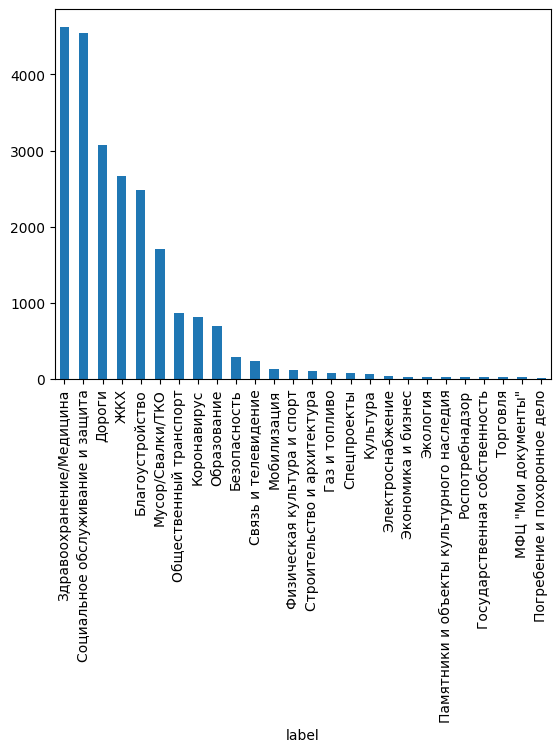

In [7]:
# classes' barplot
df.label.value_counts().plot(kind='bar')

### Text Augmentation with deep-translator

In [49]:
aug = TextAugmentation()

In [9]:
df = aug.tr_df(df, 'Погребение и похоронное дело', 10)

100%|███████████████████████████████████████████| 11/11 [00:31<00:00,  2.89s/it]
0it [00:00, ?it/s]


In [10]:
df = aug.tr_df(df, 'МФЦ "Мои документы"', 6.5)

100%|█████████████████████████████████████████████| 9/9 [00:33<00:00,  3.76s/it]


In [11]:
df = aug.tr_df(df, 'Торговля', 6)

100%|███████████████████████████████████████████| 20/20 [02:06<00:00,  6.34s/it]
0it [00:00, ?it/s]


In [12]:
df = aug.tr_df(df, 'Роспотребнадзор', 5.3)

100%|█████████████████████████████████████████████| 6/6 [00:38<00:00,  6.49s/it]


In [13]:
df = aug.tr_df(df, 'Экология', 4)

100%|███████████████████████████████████████████| 25/25 [03:33<00:00,  8.53s/it]
0it [00:00, ?it/s]


In [14]:
df = aug.tr_df(df, 'Памятники и объекты культурного наследия', 5.3)

100%|█████████████████████████████████████████████| 6/6 [00:34<00:00,  5.69s/it]


In [15]:
df = aug.tr_df(df, 'Государственная собственность', 5.3)

100%|█████████████████████████████████████████████| 6/6 [00:31<00:00,  5.32s/it]


In [16]:
df = aug.tr_df(df, 'Экономика и бизнес', 4.3)

100%|█████████████████████████████████████████████| 8/8 [01:02<00:00,  7.82s/it]


In [17]:
df = aug.tr_df(df, 'Электроснабжение', 2.5)

100%|███████████████████████████████████████████| 18/18 [02:48<00:00,  9.37s/it]


In [18]:
df = aug.tr_df(df, 'Газ и топливо', 2.2)

100%|███████████████████████████████████████████| 16/16 [02:20<00:00,  8.80s/it]


In [50]:
df = aug.tr_df(df, 'Спецпроекты', 2.2)

100%|███████████████████████████████████████████| 16/16 [02:13<00:00,  8.33s/it]


In [51]:
# aug result
df

,Исполнитель,label,text,Тема
0,Лысьвенский городской округ,Благоустройство,"Добрый день. Сегодня,.., моя мать шла по улице...",★ Ямы во дворах
1,Министерство социального развития ПК,Социальное обслуживание и защита,"Пермь г,. В Перми с ноября года не работает со...",Оказание гос. соц. помощи
2,Министерство социального развития ПК,Социальное обслуживание и защита,Добрый день! Скажите пожалуйста если подавала ...,Дети и многодетные семьи
3,Город Пермь,Общественный транспорт,Каждая из них не о чем. Люди на остановках хот...,Содержание остановок
4,Министерство здравоохранения,Здравоохранение/Медицина,В Березниках у сына принятого откоронавируса з...,Технические проблемы с записью на прием к врачу
...,...,...,...,...
23779,NaN,Спецпроекты,Мир вам. Что значит побег? Почему вам следует ...,NaN
23780,NaN,Спецпроекты,город Пермь. Спокойной ночи. Шум в этом году н...,NaN
23781,NaN,Спецпроекты,,NaN
23782,NaN,Спецпроекты,город Пермь. Куда писать негативные отзывы о б...,NaN


In [52]:
# aug classes' distribution
df.label.value_counts()

label
Здравоохранение/Медицина                    4625
Социальное обслуживание и защита            4550
Дороги                                      3078
ЖКХ                                         2664
Благоустройство                             2482
Мусор/Свалки/ТКО                            1701
Общественный транспорт                       862
Коронавирус                                  808
Образование                                  693
Безопасность                                 292
Связь и телевидение                          229
Газ и топливо                                178
Спецпроекты                                  178
Мобилизация                                  130
Памятники и объекты культурного наследия     121
Роспотребнадзор                              121
Экономика и бизнес                           120
Физическая культура и спорт                  120
Торговля                                     120
МФЦ "Мои документы"                          117
Государственна

### Matching 'Тема' aug data with 'Тема' original data

<AxesSubplot: xlabel='label'>

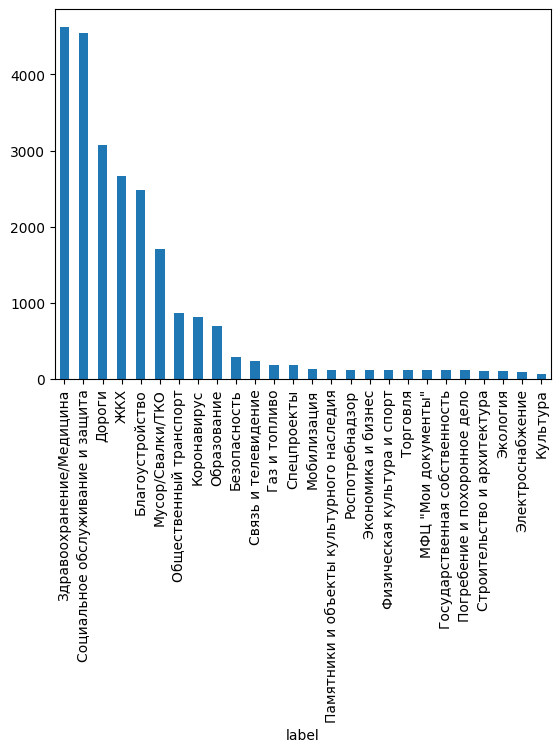

In [53]:
# new classes' barplot
df.label.value_counts().plot(kind='bar')

In [146]:
augmented_df = df[df.isnull()['Тема'] == True].reset_index(drop=True)
augmented_df.head(3)

,Исполнитель,label,text,Тема
0,NaN,Погребение и похоронное дело,Мусоросжигательный завод строится! Кладбище бо...,NaN
1,NaN,Погребение и похоронное дело,"Хочу добавить к посту, почему больницы не сооб...",NaN
2,NaN,Погребение и похоронное дело,В нашей Красновишерской скорой помощи при звон...,NaN


In [147]:
df_orig = pd.read_csv('preprocessed.csv', sep=';')
df_orig.head(3)

,Исполнитель,Группа тем,Текст инцидента,Тема
0,Лысьвенский городской округ,Благоустройство,"Добрый день. Сегодня,.., моя мать шла по улице...",★ Ямы во дворах
1,Министерство социального развития ПК,Социальное обслуживание и защита,"Пермь г,. В Перми с ноября года не работает со...",Оказание гос. соц. помощи
2,Министерство социального развития ПК,Социальное обслуживание и защита,Добрый день! Скажите пожалуйста если подавала ...,Дети и многодетные семьи


In [148]:
# returning labels 'Тема' to aug data
# it's an adaption of method TextAugmentation.tr_df()
def return_small_label(df, label, mult):
    result = []
    num_rows = df[df['Группа тем'] == label].shape[0]
    
    for i in range(int(mult-1)):
        small_labels = df[df['Группа тем'] == label]['Тема']
        result.append(small_labels)
        
    small_labels = df[df['Группа тем'] == label].iloc[:int(mult%1*num_rows)]['Тема']
    result.append(small_labels)
    
    return pd.concat(result, ignore_index=True)

In [149]:
aug_classes = {'Погребение и похоронное дело': 10, 
               'МФЦ "Мои документы"': 6.5,
               'Торговля': 6, 
               'Роспотребнадзор': 5.3, 
               'Экология': 4, 
               'Памятники и объекты культурного наследия': 5.3, 
               'Государственная собственность': 5.3, 
               'Экономика и бизнес': 4.3, 
               'Электроснабжение': 2.5, 
               'Газ и топливо': 2.2, 
               'Спецпроекты': 2.2}

In [150]:
# returning labels 'Тема' to aug data

res = []
for label, mult in aug_classes.items():
    res.append(return_small_label(df_orig, label, mult))

In [151]:
aug_labels = pd.concat(res, ignore_index=True)
aug_labels.shape

(1004,)

In [152]:
augmented_df.label.shape

(1004,)

In [153]:
# renaming df
augmented_df['Тема'] = aug_labels
augmented_df = augmented_df[['text', 'label', 'Тема']]
augmented_df.columns = ['text', 'big_labels', 'smol_labels']

In [154]:
augmented_df

,text,big_labels,smol_labels
0,Мусоросжигательный завод строится! Кладбище бо...,Погребение и похоронное дело,Погребение и похоронное дело
1,"Хочу добавить к посту, почему больницы не сооб...",Погребение и похоронное дело,Погребение и похоронное дело
2,В нашей Красновишерской скорой помощи при звон...,Погребение и похоронное дело,Погребение и похоронное дело
3,В Кудимкале похоронные компании платят налоги ...,Погребение и похоронное дело,Погребение и похоронное дело
4,"Крематории, безусловно, нужны. Посмотрите коли...",Погребение и похоронное дело,Погребение и похоронное дело
...,...,...,...
999,Мир вам. Что значит побег? Почему вам следует ...,Спецпроекты,Спецпроекты
1000,город Пермь. Спокойной ночи. Шум в этом году н...,Спецпроекты,Спецпроекты
1001,,Спецпроекты,Спецпроекты
1002,город Пермь. Куда писать негативные отзывы о б...,Спецпроекты,Спецпроекты


In [155]:
# deleting trash 
augmented_df.text = augmented_df.text.apply(lambda x: None if len(x) <= 3 else x)

In [158]:
augmented_df = augmented_df.dropna()
augmented_df

,text,big_labels,smol_labels
0,Мусоросжигательный завод строится! Кладбище бо...,Погребение и похоронное дело,Погребение и похоронное дело
1,"Хочу добавить к посту, почему больницы не сооб...",Погребение и похоронное дело,Погребение и похоронное дело
2,В нашей Красновишерской скорой помощи при звон...,Погребение и похоронное дело,Погребение и похоронное дело
3,В Кудимкале похоронные компании платят налоги ...,Погребение и похоронное дело,Погребение и похоронное дело
4,"Крематории, безусловно, нужны. Посмотрите коли...",Погребение и похоронное дело,Погребение и похоронное дело
...,...,...,...
998,"город Пермь. Добрый вечер, адрес: ул. Водонагр...",Спецпроекты,Спецпроекты
999,Мир вам. Что значит побег? Почему вам следует ...,Спецпроекты,Спецпроекты
1000,город Пермь. Спокойной ночи. Шум в этом году н...,Спецпроекты,Спецпроекты
1002,город Пермь. Куда писать негативные отзывы о б...,Спецпроекты,Спецпроекты


In [159]:
# saving
augmented_df.to_csv('augmented_translator.csv', index=False)